In [69]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from tqdm.notebook import tqdm

In [70]:
api = wandb.Api()

In [71]:
sweep_ids = ("sibdeh7u",)
sweeps = [api.sweep(f"project-avengers/goon-test/sweeps/{sweep_id}") for sweep_id in sweep_ids]

In [72]:
results = []
for s in sweeps:
    runs = s.runs
    for r in tqdm(runs):
        if r.state == "finished":
            config = deepcopy(r.config)
            last_loss =[x for x in r.scan_history(min_step=config["num_steps"], keys=["loss"])]
            assert len(last_loss) == 1
            config["loss"] = last_loss[0]["loss"]
            results.append(config)

  0%|          | 0/132 [00:00<?, ?it/s]

In [73]:
results_df = pd.DataFrame(results)
results_df

,mup,optim,d_model,n_layer,tracker,weights,col_name,datasets,head_dim,bos_token,...,seq_length,vocab_size,world_size,learning_rate,tokenizer_path,report_interval,mup_base_d_model,use_torch_compile,mup_simple_scaling_impl,loss
0,False,adamw,8196,8,wandb,1,contents,dataset=cc_en_head,128,None,...,512,128256,8,0.000100,/datasets/tokenizers/llama3,64,256,False,False,4.259100
1,True,adamw,8196,8,wandb,1,contents,dataset=cc_en_head,128,None,...,512,128256,8,0.000100,/datasets/tokenizers/llama3,64,256,False,False,6.082508
2,False,adamw,8196,8,wandb,1,contents,dataset=cc_en_head,128,None,...,512,128256,8,0.000158,/datasets/tokenizers/llama3,64,256,False,False,4.249056
3,True,adamw,8196,8,wandb,1,contents,dataset=cc_en_head,128,None,...,512,128256,8,0.000158,/datasets/tokenizers/llama3,64,256,False,False,5.758860
4,False,adamw,8196,8,wandb,1,contents,dataset=cc_en_head,128,None,...,512,128256,8,0.000251,/datasets/tokenizers/llama3,64,256,False,False,4.459470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,False,adamw,256,8,wandb,1,contents,dataset=cc_en_head,128,None,...,512,128256,8,0.003981,/datasets/tokenizers/llama3,64,256,False,False,4.443803
128,False,adamw,256,8,wandb,1,contents,dataset=cc_en_head,128,None,...,512,128256,8,0.006310,/datasets/tokenizers/llama3,64,256,False,False,4.463897
129,True,adamw,256,8,wandb,1,contents,dataset=cc_en_head,128,None,...,512,128256,8,0.006310,/datasets/tokenizers/llama3,64,256,False,False,4.851304
130,False,adamw,256,8,wandb,1,contents,dataset=cc_en_head,128,None,...,512,128256,8,0.010000,/datasets/tokenizers/llama3,64,256,False,False,4.759072


In [74]:
non_nan_results_df = results_df[results_df.loss != "NaN"]
print(f"Removed {len(results_df) - len(non_nan_results_df)} NaNs")

Removed 0 NaNs


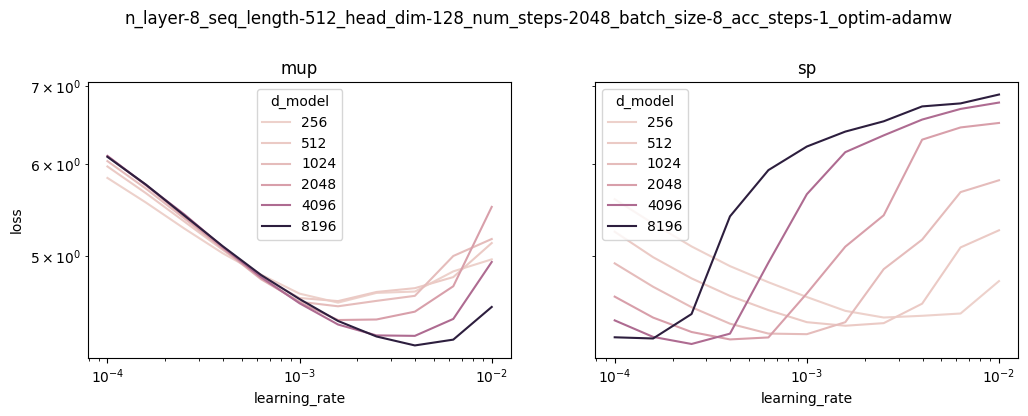

In [76]:
fig, axs = plt.subplots(                                                  
 ncols=2, nrows=1, sharey=True, sharex=True, figsize=(6 * 2, 4 ) 
)                                                                         
mup_plot =sns.lineplot(data=non_nan_results_df[non_nan_results_df.mup], x="learning_rate", y="loss", hue="d_model", ax=axs[0])
axs[0].set_title("mup")
no_mup_plot = sns.lineplot(data=non_nan_results_df[~non_nan_results_df.mup], x="learning_rate", y="loss", hue="d_model", ax=axs[1])
axs[1].set_title("sp")
mup_plot.set(xscale="log")
mup_plot.set(yscale="log")
no_mup_plot.set(xscale="log")
no_mup_plot.set(yscale="log")

suptitle = f'n_layer-{config.get("n_layer")}_seq_length-{config.get("seq_length")}_head_dim-{config.get("head_dim")}_num_steps-{config.get("num_steps")}_batch_size-{config.get("batch_size")}_acc_steps-{config.get("acc_steps",1)}_optim-{config.get("optim")}'

fig.suptitle(suptitle)
fig.subplots_adjust(top=0.8)
fig.savefig(suptitle + ".png", dpi=256, bbox_inches="tight")